# A guide through compilation in Python using Electrostatics

On the computation of the follow values

$$\sum_{i >j } \frac{q_i q_j}{r_{ij}}$$

In [1]:
import numpy as np
import cython
import numexpr
%load_ext cython
%matplotlib inline

ModuleNotFoundError: No module named 'numexpr'

In [27]:
def build_system(n, extent=(10, 10, 10), q=(-10, 10)):
    """Constucts a trial system in cartesian coordinates with random charges.
    """
    xyz = np.random.rand(n, 3) * np.array(extent)
    q = np.random.randint(*q, size=n)
    return (xyz, q)

In [52]:
xyz, q = build_system(10000)
# print(xyz)
# print(q)

In [32]:
def naive_electrostatics(xyz, q):
    """Electostatics with simply python for loops
    """
    ret = 0.0
    size = xyz.shape[0]
    for x in range(size):
        for y in range(x + 1, size):
            dx = xyz[x, 0] - xyz[y, 0]
            dy = xyz[x, 1] - xyz[y, 1]
            dz = xyz[x, 2] - xyz[y, 2]
            
            r = (dx * dx + dy * dy + dz * dz) ** 0.5
            ret += q[x] * q[y] / r
    return ret

print(naive_electrostatics(xyz, q))
ttime = %timeit -o naive_electrostatics(xyz, q)
print(ttime)
print(ttime.all_runs)
print(ttime.worst)

-711.8376591283366
100 loops, best of 3: 18.6 ms per loop
[1.8590777660137974, 1.9052599259885028, 1.8602436679939274]
0.026212372991722077


In [33]:
def numpy_electrostatics(xyz, q):
    """Electostatics with simply python for loops
    """
    ret = 0.0
    size = xyz.shape[0]
    for x in range(size):
        dxyz = xyz[:x] - xyz[x]
        r = np.sqrt(np.einsum('ij,ij->i', dxyz, dxyz))
        ret += np.sum(q[:x] * q[x] / r)
    return ret

print(naive_electrostatics(xyz, q))
%timeit numpy_electrostatics(xyz, q)

-711.8376591283366
1000 loops, best of 3: 1.38 ms per loop


## Cython implementation

In [38]:
%%cython --annotate

def cython1_electrostatics(xyz, q):
    """Electostatics with simply python for loops
    """
    ret = 0.0
    size = xyz.shape[0]
    for x in range(size):
        for y in range(x + 1, size):
            dx = xyz[x, 0] - xyz[y, 0]
            dy = xyz[x, 1] - xyz[y, 1]
            dz = xyz[x, 2] - xyz[y, 2]
            
            r = (dx * dx + dy * dy + dz * dz) ** 0.5
            ret += q[x] * q[y] / r
    return ret


In [36]:
print(cython1_electrostatics(xyz, q))
%timeit cython1_electrostatics(xyz, q)

-711.8376591283366
100 loops, best of 3: 17.6 ms per loop


In [42]:
%%cython --annotate

cimport cython
cimport numpy as np

def cython2_electrostatics(np.ndarray[np.double_t, ndim=2] xyz, np.ndarray[np.int_t, ndim=1] q):
    """Electostatics with simply python for loops
    """
    cdef np.double_t ret = 0.0
    cdef int size = xyz.shape[0]
    
    cdef np.double_t dx, dy, dz, r
    cdef int x, y
    
    for x in range(size):
        for y in range(x + 1, size):
            dx = xyz[x, 0] - xyz[y, 0]
            dy = xyz[x, 1] - xyz[y, 1]
            dz = xyz[x, 2] - xyz[y, 2]
            
            r = (dx * dx + dy * dy + dz * dz) ** 0.5
            ret += q[x] * q[y] / r
    return ret

In [43]:
print(cython2_electrostatics(xyz, q))
%timeit cython2_electrostatics(xyz, q)

-711.8376591283366
10000 loops, best of 3: 22.3 µs per loop


In [48]:
%%cython

cimport cython
cimport cython.parallel
cimport numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True) 
def cython3_electrostatics(np.ndarray[np.double_t, ndim=2] xyz, np.ndarray[np.int_t, ndim=1] q):
    """Electostatics with simply python for loops
    """
    cdef np.double_t ret = 0.0
    cdef int size = xyz.shape[0]
    
    cdef np.double_t dx, dy, dz, r
    cdef int x, y
    
    for x in cython.parallel.prange(size, nogil=True, schedule="guided"):
        for y in range(x + 1, size):
            dx = xyz[x, 0] - xyz[y, 0]
            dy = xyz[x, 1] - xyz[y, 1]
            dz = xyz[x, 2] - xyz[y, 2]
            
            r = (dx * dx + dy * dy + dz * dz) ** 0.5
            ret += q[x] * q[y] / r
    return ret

In [49]:
print(cython3_electrostatics(xyz, q))
%timeit cython3_electrostatics(xyz, q)

-711.8376591283366
The slowest run took 6.77 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 15.8 µs per loop


# Numba

In [53]:
import numba
jit_electrostatics = numba.jit(naive_electrostatics, nopython=True)

print(jit_electrostatics(xyz, q))
%timeit jit_electrostatics(xyz, q)

1603888.4106917907
1 loop, best of 3: 205 ms per loop


In [54]:
def prange_electrostatics(xyz, q):
    """Electostatics with simply python for loops
    """
    ret = 0.0
    size = xyz.shape[0]
    for x in numba.prange(size):
        for y in range(x + 1, size):
            dx = xyz[x, 0] - xyz[y, 0]
            dy = xyz[x, 1] - xyz[y, 1]
            dz = xyz[x, 2] - xyz[y, 2]
            
            r = (dx * dx + dy * dy + dz * dz) ** 0.5
            ret += q[x] * q[y] / r
    return ret

jit_prange_electrostatics = numba.jit(prange_electrostatics, nopython=True, parallel=True)

print(jit_prange_electrostatics(xyz, q))
%timeit jit_prange_electrostatics(xyz, q)

1603888.4106918657
10 loops, best of 3: 59.6 ms per loop


In [ ]:
# Required CUDA GPU's 'conda install cudatoolkit
#gpujit_prange_electrostatics = numba.cuda.jit(prange_electrostatics, nopython=True)

# print(gpujit_prange_electrostatics(xyz, q))
# %timeit gpujit_prange_electrostatics(xyz, q)

In [55]:
import seaborn
import pandas as pd

func_dict = {
    "python": naive_electrostatics,
    "numpy": numpy_electrostatics,
    "cython2": cython2_electrostatics,
    "cython3": cython3_electrostatics,
    "jit": jit_electrostatics,
    "jit_prange": jit_prange_electrostatics,
}

active = {k : True for k in func_dict.keys()}

sizes = [1e1, 1e2, 1e3, 1e4]
df = []

for s in sizes:
    tmp_xyz, tmp_q = build_system(int(s))
    print("\nTimes for size {}".format(s))
    print("----------------------------")
    for name, func in func_dict.items():
        

        # Filter out very long runs
        if not active[name]:
            continue
            
        print("\nTiming function {}:".format(name))

        
        timing = %timeit -o func(tmp_xyz, tmp_q)
        df.append([s, name, timing.best])
        
        if timing.best > 0.5:
            active[name] = False

df = pd.DataFrame(df, columns=["Size", "Algorithm", "Time [s]"])


Times for size 10.0
----------------------------

Timing function python:
10000 loops, best of 3: 169 µs per loop

Timing function numpy:
10000 loops, best of 3: 121 µs per loop

Timing function cython2:
The slowest run took 4.77 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 1.1 µs per loop

Timing function cython3:
The slowest run took 7.49 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 1.14 µs per loop

Timing function jit:
The slowest run took 9.52 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 627 ns per loop

Timing function jit_prange:
The slowest run took 4.85 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 39.3 µs per loop

Times for size 100.0
----------------------------

Timing function python:
10

In [56]:
df

,Size,Algorithm,Time [s]
0,10.0,python,1.689848e-04
1,10.0,numpy,1.213316e-04
2,10.0,cython2,1.104367e-06
3,10.0,cython3,1.140527e-06
4,10.0,jit,6.270996e-07
5,10.0,jit_prange,3.931832e-05
6,100.0,python,1.976699e-02
7,100.0,numpy,1.451774e-03
8,100.0,cython2,2.352527e-05
9,100.0,cython3,1.633833e-05


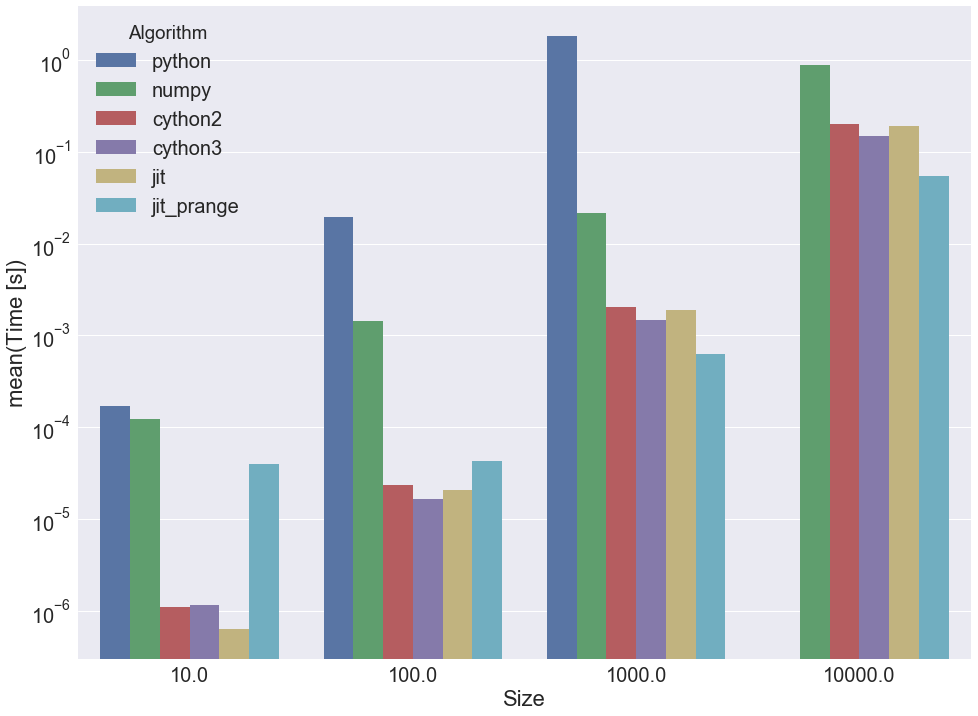

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=2)
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)

g = sns.barplot(x="Size", y="Time [s]", hue="Algorithm", data=df, ax=ax)
g.set_yscale('log')

# Numexpr

In [58]:
size = int(1e6)

a = np.random.rand(size)
b = np.random.rand(size)
c = np.random.rand(size)

In [59]:
def numpy_expression(a, b, c):
    return np.sin(a) + np.exp(b) + np.tan(c)

In [60]:
%timeit numpy_expression(a, b, c)

10 loops, best of 3: 30.4 ms per loop


In [61]:
jit_expression = numba.jit(numpy_expression, nopython=True)
%timeit jit_expression(a, b, c)

The slowest run took 6.46 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 26.6 ms per loop


In [62]:
t = %timeit -o numexpr.evaluate("sin(a) + exp(b) + tan(c)", {"a": a, "b": b, "c": c})

The slowest run took 26.59 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 2.67 ms per loop


In [ ]:
t.all_runs